# Genetic Algorithm

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [2]:
# The following class will be used to create a list of 50 different locations which must be visited at least once.
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        return np.sqrt((xDis ** 2) + (yDis ** 2))
    
    def __repr__(self):
        # Este método cambia la representación de los objetos creados. Esto será útil
        # para cuando las ciudades creadas sean ingresadas a listas.
        return "(" + str(self.x) + "," + str(self.y) + ")"

## Fitness value

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.total_distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.total_distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.total_distance = pathDistance
        return self.total_distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

# City list creation

In [4]:
# Depending on your team number, change the seed value used here so you will now which excercise to solve:
def city_locations(seed, cities, x_min_coord, x_max_coord, y_min_coord, y_max_coord):
    np.random.seed(seed)
    ruta=[]
    for i in range(1, cities+1):
        x=np.random.randint(x_min_coord, x_max_coord)
        y=np.random.randint(y_min_coord, y_max_coord)
        globals()["Ciudad_"+str(i)]= City(x,y)
        ruta.append(globals()["Ciudad_{}".format(i)])
    return ruta

In [5]:
# The following function will create a map with all the destinations that must be visited
def mapping_route(route, user_ax):
    x_min, x_max = 0,0
    y_min, y_max = 0,0
    for city in (route):
        user_ax.plot(city.x,city.y,marker='o', markersize=5, color="green")
        if city.x<x_min:
            x_min=city.x
        if city.x>x_max:
            x_max=city.x
        if city.y<y_min:
            y_min=city.y
        if city.y>y_max:
            y_max=city.y
    user_ax.set_xlim([x_min*1.25, x_max*1.25])
    user_ax.set_ylim([y_min*1.25, y_max*1.25])
    return user_ax

In [6]:
def walked_route(selected_route, user_ax):
    user_ax=mapping_route(selected_route, user_ax)
    X=[city.x for city in selected_route]
    Y=[city.y for city in selected_route]
    X.append(X[0])
    Y.append(Y[0])
    user_ax.plot(X,Y)
    user_ax.plot(X[0],Y[0], marker="x", markersize=5, color="red", markeredgewidth=4)
    return user_ax

In [7]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [8]:
# Matrix distance from using all possible combinations between cities
def distance_matrix(route):
    matriz=np.zeros((len(route),len(route)))
    for i in range(matriz.shape[0]):
        X=route[i]
        for j in range(matriz.shape[1]):
            Y=route[j]
            matriz[i][j]=X.distance(Y)
    filas=["Ciudad"+str(i+1) for i in range(matriz.shape[0])]
    columnas=["Ciudad"+str(i+1) for i in range(matriz.shape[1])]
    df = pd.DataFrame(data=matriz, index=filas, columns=columnas)
    return df

## First generation

In [9]:
# For the current excercise consider a population size of 20
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Rankeando las soluciones

In [10]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Survival of the fittest

In [11]:
# For the current excercise consider an elite size of 10
def selection(popRanked, eliteSize):
    selectionResults = []

    for i in range(eliteSize):
        selectionResults.append(popRanked[i][0])
    
    for i in range(len(popRanked) - eliteSize):
        num=np.random.randint(0,len(popRanked))
        selectionResults.append(popRanked[num][0])
    return selectionResults

## Breeding and mutation

In [12]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [13]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    # Random selection of the starting and ending points of parent's genes
    index1 = random.randint(0, len(parent1)-1)
    index2 = random.randint(0, len(parent1)-1)
    
    startGene = min(index1, index2)
    endGene = max(index1, index2)
    
    # Slicing first parent by using the starting and end Genes selected
    childP1=parent1[startGene:endGene]
    
    # The remaining values will come from parent2; only those values that hasn´t been
    # selected yet from parent 1 will be chosen in the order that parent2 has.
    childP2 = [item for item in parent2 if item not in childP1]
    
    # A new solution is born
    child = childP1 + childP2
    return child

In [14]:
# Function to create a new population
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))
    
    # Members from the elite size will become automatically solutions
    # for the next generation
    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    # The remaining spots for the following generation will be filled
    # using the breed function
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [15]:
# This function will provide the randomness of mutation in one of the possible routes. 

def mutate(individual, mutationRate):
    # Checking for every city if it will mutate or not
    for possible_swapped in range(len(individual)):
        # If the random value generated is lower than the mutation rate,
        # then the mutation process will begin.
        if(random.random() < mutationRate):
            # The selected city will be swapped with other city position
            # within the solution
            swap_index = random.randint(0, len(individual)-1)
            city1 = individual[possible_swapped]
            city2 = individual[swap_index]
            
            # Swapping process
            individual[possible_swapped] = city2
            individual[swap_index] = city1
    return individual

In [16]:
# This function will provide the randomness of mutation in the new born generation
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

# Putting all together

In [17]:
# This function ensembles everything together as part of the breeding process
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [18]:
# This function provides the for loop needed to create several generations

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    '''
    1. population = (list) List of all the cities that have to be visited
    2. popSize = (int) Number of solutions to be considered as part of each generation
    3. eliteSize = (int) Number of chosen solutions according to their fitness value
    4. mutationRate = (float) Floating point value indicating the percentage of genes to be swapped within a solution
    5. generations = (int) Number of generations to create in order to achieve convergence
    '''
    # The following two lines will create the first generation and will give some info about it
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    # The following two lines will keep track on how well is each generation performing
    # It will store the best fitness value of each generation
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    # This for loop will iterate over the number of generations that our algorithm will use
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute, progress

In [19]:
# This function makes use of the walked_route previously created and joins it with the genetic algorithm
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations, user_ax):
    bestRoute, progress = geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations)
    
    walked_route(population, user_ax[0])
    user_ax[0].set_title('Starting possible solution')
    user_ax[1].plot(progress)
    user_ax[1].set_ylabel('Distance')
    user_ax[1].set_xlabel('Generation')
    user_ax[1].set_title('Algorithm Convergence')
    walked_route(bestRoute, user_ax[2])
    user_ax[2].set_title("Last possible solution obtained\n with " + str(generations) + " generations used")
    plt.show()

Initial distance: 2319.7491330254657
Final distance: 602.4308936145858


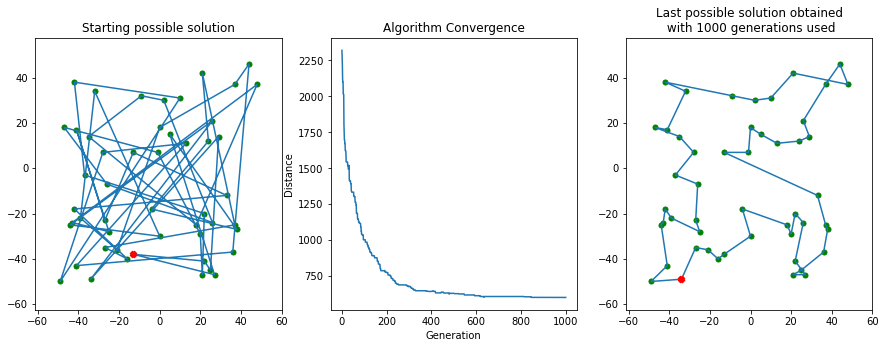

In [28]:
%timeit
cityList=city_locations(1, 50, -50, 50, -50, 50)
fig, axs=plt.subplots(1,3, figsize=(15,5))
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=30, 
                     mutationRate=0.001, generations=1000, user_ax=axs)
plt.show()

Initial distance: 2059.524910224378
Final distance: 574.8089021209698


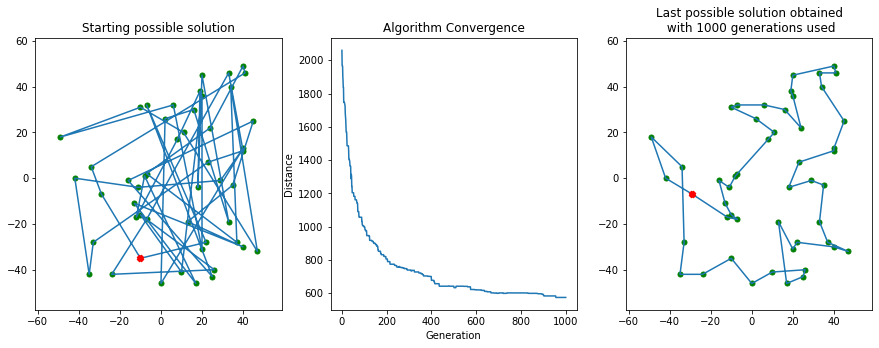

In [29]:
%timeit
cityList=city_locations(2, 50, -50, 50, -50, 50)
fig, axs=plt.subplots(1,3, figsize=(15,5))
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=30, 
                     mutationRate=0.001, generations=1000, user_ax=axs)
plt.show()